In [41]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## 데이터 로드 및 처리
- 평점 데이터 join 
- db data, test data split

In [42]:
df = pd.read_csv('./getamped.csv', index_col = 0)
df.head()

,계급,액세서리
0,동황룡,"철장갑,파이어크로스,미스터리테트라,우리엘머누버,산타구두"
1,금청룡,"호루스의가면,키메라건틀릿,미스터리테트라,미스터리오브,미스터리큐브"
2,금청룡,"거합태도,무형검,연태도,오오덴타,그림펜듈럼"
3,은청룡,"아톰비트,트롤의팔,암레이저건,쌍권총,프로스트서번트"
4,은청룡,"거합태도,연태도,브르위프,오오덴타,플레어플레일"


In [43]:
df_score = pd.read_csv('./겟앰상점악평점.csv', encoding = 'cp949').iloc[:,1:]
df_score.head()

,액세서리,외형,성능,재미
0,공수도플레임,8.8,9.2,9.5
1,황혼의달,9.3,8.5,8.5
2,프로즌글러브,8.8,8.9,8.8
3,봉인의지팡이(퍼플),5.8,7.8,6.2
4,아쿠아기어,9.5,9.7,9.7


In [44]:
# 각 유저별 사용 액세서리에 따른 외형, 성능, 재미 평점 산출

df['외형'], df['성능'], df['재미'] = 0, 0, 0
for idx in range(len(df)):
    s_외형, s_성능, s_재미 = 0, 0, 0
    n = len(df['액세서리'][idx].split(','))
    for acc in df['액세서리'][idx].split(','):
        s_외형 += float(df_score.query(f'`액세서리` == "{acc}"')['외형'].values[0])
        s_성능 += float(df_score.query(f'`액세서리` == "{acc}"')['성능'].values[0])
        s_재미 += float(df_score.query(f'`액세서리` == "{acc}"')['재미'].values[0])
        
    df.loc[idx, '외형'] = round(s_외형/n, 3)
    df.loc[idx, '성능'] = round(s_성능/n, 3)
    df.loc[idx, '재미'] = round(s_재미/n, 3)
    
df.head()

,계급,액세서리,외형,성능,재미
0,동황룡,"철장갑,파이어크로스,미스터리테트라,우리엘머누버,산타구두",9.42,9.40,9.40
1,금청룡,"호루스의가면,키메라건틀릿,미스터리테트라,미스터리오브,미스터리큐브",9.42,9.50,9.38
2,금청룡,"거합태도,무형검,연태도,오오덴타,그림펜듈럼",9.52,9.30,9.32
3,은청룡,"아톰비트,트롤의팔,암레이저건,쌍권총,프로스트서번트",8.98,9.10,9.16
4,은청룡,"거합태도,연태도,브르위프,오오덴타,플레어플레일",9.34,9.08,9.18


In [46]:
# 계급별 labeling
class_level = {
    '금황룡' : 0, '은황룡' : 1, '동황룡' : 2, '금청룡' : 3, '은청룡' : 4, '동청룡' : 5, '금백호' : 6, '은백호' : 7, '동백호' : 8, '금주작' : 9, '은주작' : 10,
       '동주작' : 11, '금현무' : 12, '은현무' : 13, '동현무' : 14, '금코발' : 15, '은코발' : 16, '동코발' : 17, '금곰발' : 18, '은곰발' : 19,
       '동곰발' : 20
}


df['계급_label'] = df['계급'].map(class_level)

df.head()

,계급,액세서리,외형,성능,재미,계급_label
0,동황룡,"철장갑,파이어크로스,미스터리테트라,우리엘머누버,산타구두",9.42,9.40,9.40,2
1,금청룡,"호루스의가면,키메라건틀릿,미스터리테트라,미스터리오브,미스터리큐브",9.42,9.50,9.38,3
2,금청룡,"거합태도,무형검,연태도,오오덴타,그림펜듈럼",9.52,9.30,9.32,3
3,은청룡,"아톰비트,트롤의팔,암레이저건,쌍권총,프로스트서번트",8.98,9.10,9.16,4
4,은청룡,"거합태도,연태도,브르위프,오오덴타,플레어플레일",9.34,9.08,9.18,4


In [47]:
# db data, test set 선택
db_data = df.iloc[:199, :]
test = df.iloc[199:, :]
test.head()

,계급,액세서리,외형,성능,재미,계급_label
199,금백호,"미스터리큐브,골든글레이브,혼돈의불꽃,쌍수검열화,로켓트펀치",9.30,9.24,9.22,6
200,은백호,"거합태도,블레이드디스크,베지파머,외계인인형,미스터제빵왕",9.36,9.28,9.50,7
201,동백호,"트랜스볼,쉐도우서번트,트롤의팔,아크로니카소드,탐과젤리",9.24,9.32,9.42,8
202,금주작,"예티의팔,아그니링,로켓트펀치,스팀플라이어,트랜스볼",9.00,9.04,9.18,9
203,동청룡,"브로즈레이지,페리톤의뿔,미끌미끌발사기,블리츠엣지,머신암즈",8.96,8.82,9.10,5


## Content-based Filtering 

- Cosine similarity는 평점 데이터의 분포로 유사한 값들이 나와 사용이 힘듦
- Euclidean Distance를 사용하여 해결

In [39]:
def euclid_similarity(df_score : pd.DataFrame, user_acc : list, user_level = None):
    n = len(user_acc)
    
    # data frame transpose
    df_t = df_score.T
    df_t = df_t.rename(columns = df_t.iloc[0,:]).drop(df_t.index[0])
    df_t = df_t.astype('float')# data type float로 변환
    
    # 유저의 액세서리 평점정보 초기화 및 입력
    user_acc_rating = np.zeros((n, 3))

    for idx in range(n):

        user_acc_rating[idx][0] = df_score.query(f'`액세서리` == "{user_acc[idx]}"')['외형'].values[0]
        user_acc_rating[idx][1] = df_score.query(f'`액세서리` == "{user_acc[idx]}"')['성능'].values[0]
        user_acc_rating[idx][2] = df_score.query(f'`액세서리` == "{user_acc[idx]}"')['재미'].values[0]

    # 상점 액세서리 평점정보 
    acc_rating_matrix = np.array(df_t)

    # 유클리디안 거리 계산
    result = np.zeros((1, acc_rating_matrix.shape[1]))

    for acc_rating in user_acc_rating:
    
        result += np.sum((acc_rating.reshape(3,1) - acc_rating_matrix)**2, axis = 0)

    result = pd.DataFrame(result[0]/n, columns = ['similarity'], index = df_t.columns).reset_index() #.sort_values(by = 'similarity', ascending = True)
    result.columns = ['액세서리', 'similarity']

    result = pd.merge(result, df_score, how = 'inner', on = '액세서리')

    # 유저 정보에 따른 sorting
    
    # 청룡 제외 계급은 재미 > 외형 > 성능 순 
    
    if  user_level > 5:
        
        result = result.sort_values(['similarity', '재미', '외형'], ascending = [True, False, False])
    # 청룡은 외형 > 재미 > 성능 순
    else:
        
        result = result.sort_values(['similarity', '외형', '재미'], ascending = [True, False, False])
        
    return result

In [48]:
euclid_similarity(df_score, test.iloc[0,:].액세서리.split(','), test.iloc[0,:].계급_label).head()

,액세서리,similarity,외형,성능,재미
176,아그니링,0.082,9.3,9.2,9.2
314,숄더윙,0.082,9.3,9.2,9.2
110,플레어부스터,0.084,9.3,9.3,9.2
624,초인브레스트,0.084,9.3,9.3,9.2
420,히트부스터,0.088,9.3,9.2,9.3


## User-based Collaborative Filtering  
- 위의 CBF와 같은 이유로 Euclidean Distance를 활용

In [ ]:
def user_based_collabo(df, user_acc : list, user_level = None, threshold = 0.02):
    user = np.array(df[['외형', '성능','재미']])
    user_t = np.array(df[['외형', '성능','재미']].T)

    result = np.zeros((1, user.shape[0]))

    # 유저 정보로 부터 액세서리 평점을 통한 성향도 계산
    n = len(user_acc)
    s_외형, s_성능, s_재미 = 0, 0, 0
    
    for acc in user_acc:

        s_외형 += float(df_score.query(f'`액세서리` == "{acc}"')['외형'].values[0])/n
        s_성능 += float(df_score.query(f'`액세서리` == "{acc}"')['성능'].values[0])/n
        s_재미 += float(df_score.query(f'`액세서리` == "{acc}"')['재미'].values[0])/n
    
    user_preference = np.array([s_외형, s_성능, s_재미])

    # 유저별 유사도 계산(Euclidean distance)
    result = pd.DataFrame(np.sum((user_preference.reshape(3,1) - user_t)**2, axis = 0), 
                          columns = ['user_similarity']).sort_values('user_similarity', ascending = True) 

    # threshold에 따른 유저 topn 추출
    if result.iloc[1,:].values[0] < threshold :
        result_idx = result.query(f'0 < `user_similarity` < {threshold} ').index
    
    else:
        result_idx = result.query('`user_similarity` > 0 ').head(3).index

    result = df.iloc[result_idx, :]
    
    # 유사한 유저들이 사용했던 액세서리들의 data를 호출
    # 유사 유저들이 사용했던 액세서리 listup 
    result_acc = result['액세서리'].values 
    acc_list = []
    for accs in result_acc:
        acc_list += accs.split(',')
    acc_list_dropdup = set(acc_list)
    acc_list_dropdup
    recommendation = df_score.query(f'`액세서리` in {list(acc_list_dropdup)}').reset_index(drop = True)
    recommendation.loc[:, 'count'] = 0
    recommendation
    
    # 유사 유저들이 사용한 액세서리를 counting
    while acc_list:
        acc = acc_list.pop(0)
        idx = recommendation.query(f'`액세서리` == "{acc}"').index
        recommendation.loc[idx,'count'] += 1
    
    # 계급이 청룡보다 낮으면 재미 > 외형 > 성능 순으로 추천 우선순위를 부여
    if  user_level > 5:
        
        recommendation = recommendation.sort_values(['count', '재미', '외형', '성능'], ascending = [False, False, False, False])
    # 계급이 청룡급이면 외형 > 재미 > 성능 순으로 추천 우선순위를 부여
    else:
        
        recommendation = recommendation.sort_values(['count', '외형', '재미', '성능'], ascending = [False, False, False, False])
    
    return recommendation

In [49]:
user_based_collabo(db_data, test.iloc[3,:].액세서리.split(','), user_level = 8, threshold = 0.02).head()

,액세서리,외형,성능,재미,count
28,트랜스볼,9.2,9.7,9.8,3
26,쇼크톤파,8.4,8.5,8.5,2
3,어비스인페르노,9.8,9.7,9.7,1
20,여신의횃불,9.7,9.6,9.6,1
24,외계인인형,9.6,9.6,9.6,1


## 로직을 선택하여 적용할 수 있도록 함수 작성
- 이미 사용한 액세서리는 제외하고 추천

In [ ]:
def recsys(db_user_data, db_acc_data, user_data, how = 'ubcf', threshold = 0.02, topn = 5):
    user_level = user_data.계급_label
    user_acc = user_data.액세서리.split(',')
    
    # ubcf, cbf중 택하여 추천 로직 적용
    
    if how == 'ubcf':
        result = user_based_collabo(db_user_data, user_acc, user_level = user_level, threshold = threshold).reset_index(drop = True)
        
    elif how == 'cbf':
        result = euclid_similarity(db_acc_data, user_acc, user_level = user_level).reset_index(drop = True)
        
    rec_acc_list = []

    # 이미 유저가 사용했던 액세서리는 제외하고 top n개를 추천
    print(f'{how}를 통한 추천 액세서리는 다음과 같습니다.')
    print('='*60)
    for i in range(len(result)):
        rec_acc = result['액세서리'][i]
        if rec_acc in user_acc:
            continue
        else:
            print(rec_acc, end = ' ')
            rec_acc_list.append(i)
            topn -= 1
            if topn == 0:
                break

    score = result.loc[rec_acc_list, ['외형', '성능', '재미']]

    # 추천된 액세서리들의 각 평점 평균을 리턴
    return (score.sum()/len(score)).values

In [50]:
# 사용예시 
a = recsys(db_data, df_score, test.iloc[3,:], how = 'ubcf', topn = 5)
print()
print('추천된 액세서리의 평점 평균 :', a)

ubcf를 통한 추천 액세서리는 다음과 같습니다.
쇼크톤파 어비스인페르노 여신의횃불 외계인인형 키메라건틀릿 
추천된 액세서리의 평점 평균 : [9.4  9.42 9.4 ]


## Metric 선정
- 각 평점별 MSE의 합을 Loss function으로 정의  
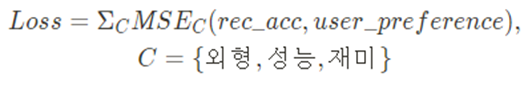

In [52]:
# MSE 계산

def mse_metric(user_score, rec_score):
    result = np.sum((user_score - rec_score)**2)
    
    return result

In [53]:
# Loss 계산

loss = 0
for i in range(len(test)):
    rec_score = recsys(db_data, df_score, test.iloc[i,:], how = 'ubcf', topn = 5)
    user_score = test.iloc[i,:][['외형','성능','재미']].values
    loss += mse_metric(user_score, rec_score)
    print(' ')

print('ubcf를 통한 test loss 값은', round(loss, 3), '입니다')

ubcf를 통한 추천 액세서리는 다음과 같습니다.
예티의팔 옥염명룡의발톱 천상의날개옷 미스터리오브 천사의링  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
쉐도우게이볼그 요정의머플러 아레스의검 일렉트릭메이스 각성카자마진  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
아이언너클 일렉트릭메이스 칠지도 크리스마스소드 천사의링  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
쇼크톤파 어비스인페르노 여신의횃불 외계인인형 키메라건틀릿  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
해골망토 열대과일바구니 미사일포트 브르위프 엽기눈사람슈트  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
산타구두 아이언너클 미스터리테트라 칠지도 파이어크로스  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
데몬핸드 산타구두 거합태도 사신의장갑 오크족토템망치  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
미사일포트 칠지도 트롤의팔 산타구두 브레이크아머  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
아이언너클 트랜스볼 크리스마스백 거합태도 오크족토템망치  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
쇼크톤파 칠지도 어인의갈퀴 진동벨트 아이시클브로우스렛  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
아이언너클 일렉트릭메이스 기간틱스매셔 로켓티어 크리스마스소드  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
산타구두 아이언너클 미스터리테트라 아이스스톤 파이어크로스  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
아이언너클 철장갑 미스터리테트라 하이퍼드럼통 칠지도  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
파워드럼통 전투마우스 미사일포트 천사의링 허실의거울  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
트랜스볼 오크족토템망치 여신의횃불 외계인인형 모던암즈  
ubcf를 통한 추천 액세서리는 다음과 같습니다.
쇼크톤파 트랜스볼 여신의횃불 외계인인형 암레이저건  
ubcf를 통한 test loss 값은 3.949 

In [54]:
loss = 0
for i in range(len(test)):
    rec_score = recsys(db_data, df_score, test.iloc[i,:], how = 'cbf', topn = 5)
    user_score = test.iloc[i,:][['외형','성능','재미']].values
    loss += mse_metric(user_score, rec_score)
    print(' ')

print('cbf를 통한 test loss 값은', round(loss, 3), '입니다')

cbf를 통한 추천 액세서리는 다음과 같습니다.
아그니링 숄더윙 플레어부스터 초인브레스트 히트부스터  
cbf를 통한 추천 액세서리는 다음과 같습니다.
로켓트펀치 테크니컬트랜서 운명의부츠 그래비톤블래스터 탐과젤리  
cbf를 통한 추천 액세서리는 다음과 같습니다.
라바보우 머신암즈 코만도암 풍뎅이투구 천사의성배  
cbf를 통한 추천 액세서리는 다음과 같습니다.
새틀라이트패널 슈퍼옵시디언 투명장갑 닥터사이코 인어의꼬리(남성용)  
cbf를 통한 추천 액세서리는 다음과 같습니다.
홀로스코프 바이오암 암바주카 예티의팔 점핑슈즈  
cbf를 통한 추천 액세서리는 다음과 같습니다.
천사의성배 브르위프 카자마진의글러브 스내쳐핸드 웜블레이드  
cbf를 통한 추천 액세서리는 다음과 같습니다.
미스터리테트라 체스크라운 블레이드디스크 스파이크쉘(블루) 쉐도우게이볼그  
cbf를 통한 추천 액세서리는 다음과 같습니다.
스켈버클러 카자마진의글러브 디재스터스피릿 풍뢰신 루시퍼링  
cbf를 통한 추천 액세서리는 다음과 같습니다.
메카레그 화끈화끈발사기 로켓티어 호버레그 강태공의낚싯대  
cbf를 통한 추천 액세서리는 다음과 같습니다.
골든글레이브 스컬발디슈 쌍검 악마의날개 태권도세트(청팀)  
cbf를 통한 추천 액세서리는 다음과 같습니다.
천사의성배 호버레그 라바보우 머신암즈 코만도암  
cbf를 통한 추천 액세서리는 다음과 같습니다.
스켈버클러 브르위프 실버비하인드 카자마진의글러브 스내쳐핸드  
cbf를 통한 추천 액세서리는 다음과 같습니다.
로켓트펀치 테크니컬트랜서 운명의부츠 걀라르호른 엽기강아지슈트  
cbf를 통한 추천 액세서리는 다음과 같습니다.
파워재킷 뇌전의지팡이 파워클리너 히어로벨트 일루젼트럼프  
cbf를 통한 추천 액세서리는 다음과 같습니다.
세인트위자드 에어마스크 무에타이세트 마수의손(황인용) 투스페어리  
cbf를 통한 추천 액세서리는 다음과 같습니다.
가고일캐논 서브마린트랜스포머 배틀크로우 고대의마법서 봉인의지팡이  
cbf를 통한 test loss 값은